In [1]:
import pickle

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz, trapz

%matplotlib widget


#############
## FORTRAN
#############

from scipy.io import FortranFile

with FortranFile('../pbuild/outputs/rho.dat', 'r') as f:
    fr = f.read_reals(dtype=np.float64)
with FortranFile('../pbuild/outputs/B.dat', 'r') as f:
    fB = f.read_reals(dtype=np.float64)
with FortranFile('../pbuild/outputs/xs.dat', 'r') as f:
    fx = f.read_reals(dtype=np.float64)

###################

m = 5
xM = 50.0
r0 = 15

k = 0

In [2]:
godunov = {}
wenor2 = {}

flux = ['', '_beta']
ts = ['2', '20']
dxs = ['0.1', '0.01', '0.001']

for dic, name in zip([godunov, wenor2], ['godunov', 'weno_r2']):
    for t in ts:
        dic[t] = {}
        for dx in dxs:
            dic[t][dx] = {}
            for fl, f in zip(flux, ['B', 'beta']):
                
                try:
                    with open(f'results/{name}_t{t}_dx{dx}{fl}.pickle', 'rb') as handle:
                        dic[t][dx][f] = pickle.load(handle)
                except FileNotFoundError:
                    print(f'results/{name}_t{t}_dx{dx}{fl}.pickle does not exists.')

                    ## Fix while t=20 dx=0.001 is being computed
                    with open(f'results/{name}_t2_dx0.001.pickle', 'rb') as handle:
                        dic[t][dx][f] = pickle.load(handle)
                    l = len(dic[t][dx][f][0]['rho_dt'])
                    dic[t][dx][f][0]['rho_dt'] = np.full(l, np.nan)
                    dic[t][dx][f][0]['rho_dx'] = np.full(l, np.nan)

results/godunov_t20_dx0.001_beta.pickle does not exists.
results/weno_r2_t20_dx0.001.pickle does not exists.


t = 2
dx = 0.001
Piecewise constant field = B

WENO - r = 2 :
Total recomputed mass with dx = 5.000000000046538
Total recomputed mass with dt = 5.00000000018767

Godunov method - first order:
Total recomputed mass with dx = 5.000000000001511
Total recomputed mass with dt = 4.99985000144737


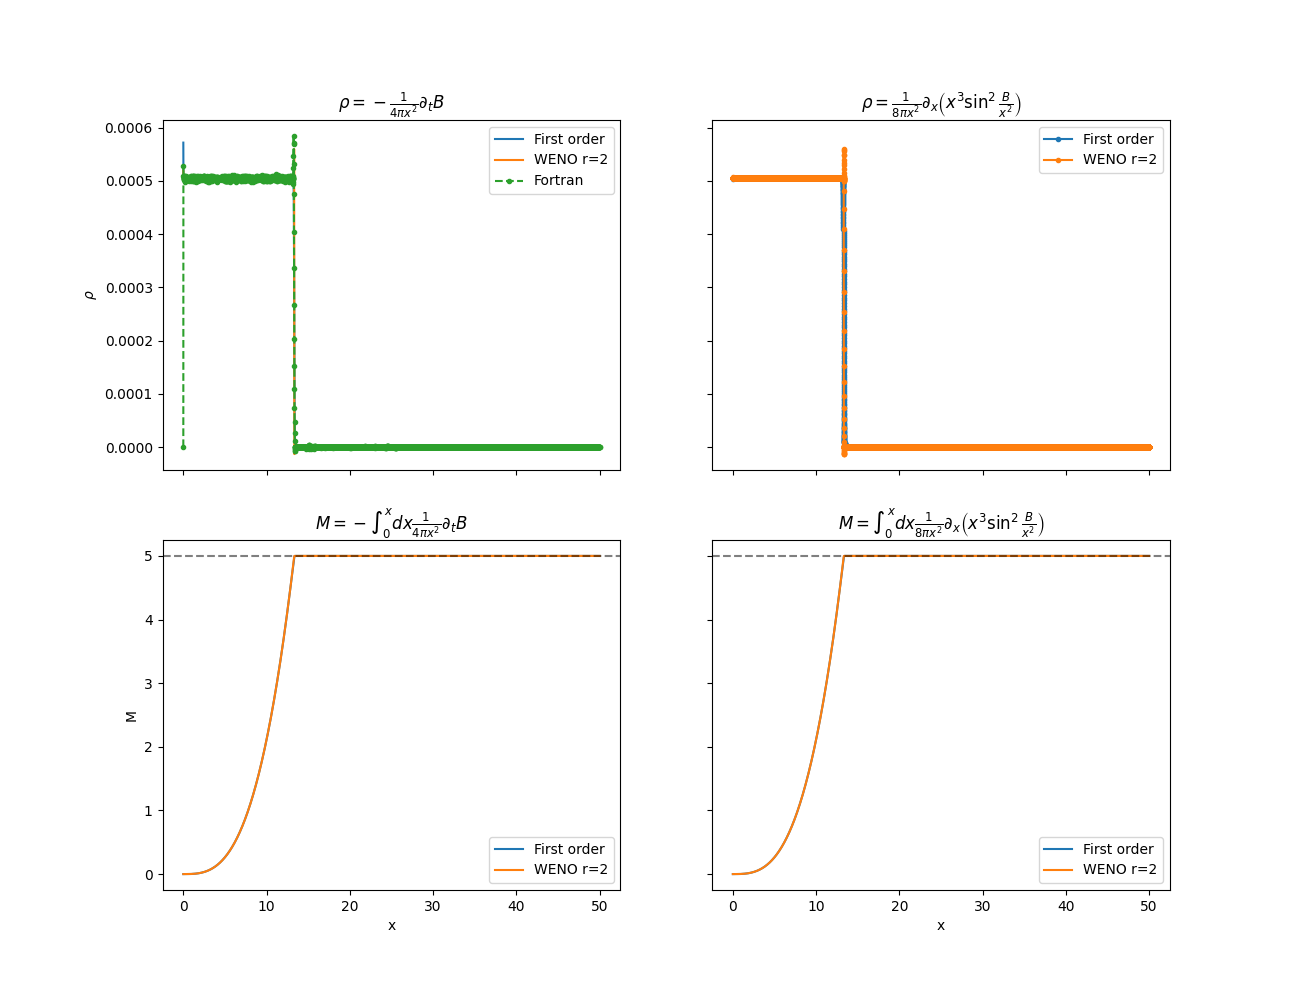

In [3]:
def compute_masses(rho, x, dx):
    return 4*np.pi * trapz(rho * x**2, dx = dx)

def plotting(godunov, wenor2, fx, frho, t, dx, f, k = 0):
    
    t = str(t)
    dx = str(dx)
    k = int(k)

    fig, axs = plt.subplots(2,2,figsize=(13, 10), sharex = True, sharey = 'row')

    axs[0,0].plot(godunov[t][dx][f][k]['x'][1:],  godunov[t][dx][f][k]['rho_dt'][1:], '-', label = 'First order')
    axs[0,0].plot(wenor2[t][dx][f][k]['x'][1:], wenor2[t][dx][f][k]['rho_dt'][1:], '-', label = 'WENO r=2')

    if (t == '2'):
        axs[0,0].plot(fx, frho, '.--', label = 'Fortran')

    axs[0,0].set_title(r"$\rho = - \frac{1}{4\pi x^2} \partial_t B $")
    axs[0,0].legend()

    axs[0,1].plot(godunov[t][dx][f][k]['x'][1:], godunov[t][dx][f][k]['rho_dx'][1:], '.-', label = 'First order')
    axs[0,1].plot(wenor2[t][dx][f][k]['x'][1:], wenor2[t][dx][f][k]['rho_dx'][1:], '.-', label = 'WENO r=2')
    axs[0,1].set_title(r"$\rho = \frac{1}{8\pi x^2} \partial_x\left( x^3 \sin^2 \frac{B}{x^2} \right)$")
    axs[0,1].legend()

    M_godu_t = 4*np.pi * cumtrapz(godunov[t][dx][f][k]['rho_dt'] * godunov[t][dx][f][k]['x']**2, initial=0) * godunov[t][dx][f][k]['dx']
    M_weno_t = 4*np.pi * cumtrapz(wenor2[t][dx][f][k]['rho_dt'] * wenor2[t][dx][f][k]['x']**2, initial=0) * wenor2[t][dx][f][k]['dx']

    axs[1,0].plot(godunov[t][dx][f][k]['x'], M_godu_t, label = 'First order' )
    axs[1,0].plot(wenor2[t][dx][f][k]['x'], M_weno_t, label = 'WENO r=2' )
    axs[1,0].axhline(m, color = 'k', ls = '--', alpha = 0.5)
    axs[1,0].set_title(r"$M = - \int_0^x dx  \frac{1}{4\pi x^2} \partial_t B $")
    axs[1,0].legend()

    M_godu_x = 4*np.pi * cumtrapz(godunov[t][dx][f][k]['rho_dx'] * godunov[t][dx][f][k]['x']**2, initial=0) * godunov[t][dx][f][k]['dx']
    M_weno_x = 4*np.pi * cumtrapz(wenor2[t][dx][f][k]['rho_dx'] * wenor2[t][dx][f][k]['x']**2, initial=0) * wenor2[t][dx][f][k]['dx']

    axs[1,1].plot(godunov[t][dx][f][k]['x'], M_godu_x, label = 'First order' )
    axs[1,1].plot(wenor2[t][dx][f][k]['x'], M_weno_x, label = 'WENO r=2' )
    axs[1,1].axhline(m, color = 'k', ls = '--', alpha = 0.5)
    axs[1,1].set_title(r"$M = \int_0^x dx \frac{1}{8\pi x^2} \partial_x\left( x^3 \sin^2 \frac{B}{x^2} \right) $")
    axs[1,1].legend()

    axs[1,0].set_xlabel('x')
    axs[1,1].set_xlabel('x')
    axs[0,0].set_ylabel(r'$\rho$')
    axs[1,0].set_ylabel('M')

    print(f"t = {t}")
    print(f"dx = {dx}")
    print(f"Piecewise constant field = {f}")
    print()
    print('WENO - r = 2 :')
    print(f"Total recomputed mass with dx = {compute_masses(wenor2[t][dx][f][k]['rho_dx'], wenor2[t][dx][f][k]['x'], wenor2[t][dx][f][k]['dx'])}")
    print(f"Total recomputed mass with dt = {compute_masses(wenor2[t][dx][f][k]['rho_dt'], wenor2[t][dx][f][k]['x'], wenor2[t][dx][f][k]['dx'])}")
    print()
    print('Godunov method - first order:')
    print(f"Total recomputed mass with dx = {compute_masses(godunov[t][dx][f][k]['rho_dx'], godunov[t][dx][f][k]['x'], godunov[t][dx][f][k]['dx'])}")
    print(f"Total recomputed mass with dt = {compute_masses(godunov[t][dx][f][k]['rho_dt'], godunov[t][dx][f][k]['x'], godunov[t][dx][f][k]['dx'])}")


plotting(godunov, wenor2, fx, fr, t = 2, dx = 0.001, f = 'B')

Time = 2


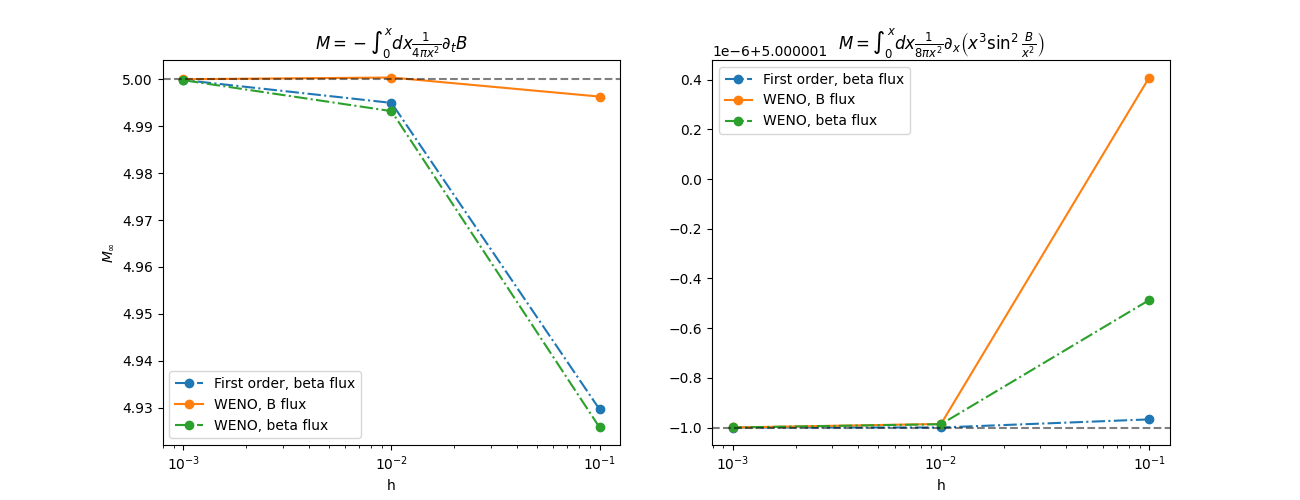

In [4]:
t = '2'

weno_ms_t = np.zeros_like(dxs, dtype=np.float64)
weno_ms_x = np.zeros_like(dxs, dtype=np.float64)
godu_ms_t_beta = np.zeros_like(dxs, dtype=np.float64)
godu_ms_x_beta = np.zeros_like(dxs, dtype=np.float64)
weno_ms_t_beta = np.zeros_like(dxs, dtype=np.float64)
weno_ms_x_beta = np.zeros_like(dxs, dtype=np.float64)

f = 'B'
for i, dx in enumerate(dxs):
    weno_ms_x[i] = compute_masses(wenor2[t][dx][f][k]['rho_dx'], wenor2[t][dx][f][k]['x'], wenor2[t][dx][f][k]['dx'])
    weno_ms_t[i] = compute_masses(wenor2[t][dx][f][k]['rho_dt'], wenor2[t][dx][f][k]['x'], wenor2[t][dx][f][k]['dx'])

f = 'beta'
for i, dx in enumerate(dxs):
    godu_ms_x_beta[i] = compute_masses(godunov[t][dx][f][k]['rho_dx'], godunov[t][dx][f][k]['x'], godunov[t][dx][f][k]['dx'])
    godu_ms_t_beta[i] = compute_masses(godunov[t][dx][f][k]['rho_dt'], godunov[t][dx][f][k]['x'], godunov[t][dx][f][k]['dx'])
    weno_ms_x_beta[i] = compute_masses(wenor2[t][dx][f][k]['rho_dx'], wenor2[t][dx][f][k]['x'], wenor2[t][dx][f][k]['dx'])
    weno_ms_t_beta[i] = compute_masses(wenor2[t][dx][f][k]['rho_dt'], wenor2[t][dx][f][k]['x'], wenor2[t][dx][f][k]['dx'])

fig, axs = plt.subplots(1,2,figsize=(13, 5), sharex = True)
axs[1].plot([float(i) for i in dxs], godu_ms_x_beta, 'o-.', label = "First order, beta flux")
axs[0].plot([float(i) for i in dxs], godu_ms_t_beta, 'o-.', label = "First order, beta flux")
axs[1].plot([float(i) for i in dxs], weno_ms_x, 'o-', label = "WENO, B flux")
axs[1].plot([float(i) for i in dxs], weno_ms_x_beta, 'o-.', label = "WENO, beta flux")
axs[0].plot([float(i) for i in dxs], weno_ms_t, 'o-', label = "WENO, B flux")
axs[0].plot([float(i) for i in dxs], weno_ms_t_beta, 'o-.', label = "WENO, beta flux")

axs[0].axhline(m, color = 'k', ls = '--', alpha = 0.5)
axs[1].axhline(m, color = 'k', ls = '--', alpha = 0.5)

axs[0].set_xlabel('h')
axs[1].set_xlabel('h')
axs[0].set_ylabel(r'$M_{\infty}$')

axs[0].set_title(r"$M = - \int_0^x dx  \frac{1}{4\pi x^2} \partial_t B $")
axs[1].set_title(r"$M = \int_0^x dx \frac{1}{8\pi x^2} \partial_x\left( x^3 \sin^2 \frac{B}{x^2} \right) $")

plt.xscale('log')

axs[0].legend()
axs[1].legend()

print(f'Time = {t}')

Time = 20
dx = 0.1


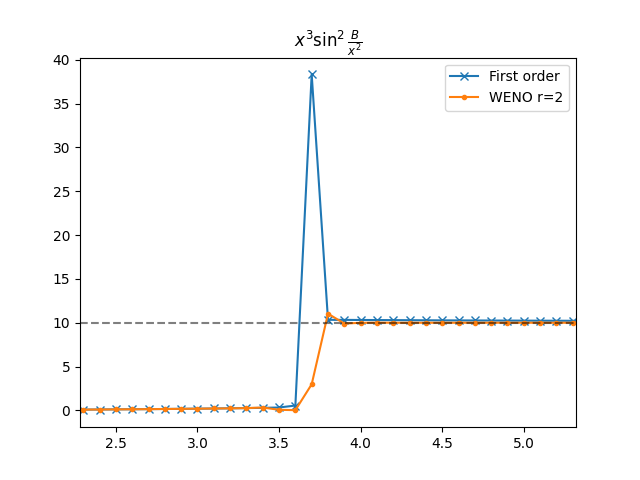

In [5]:
t = '20'
dx = '0.1'
f = 'B'

fun_godu = godunov[t][dx][f][k]['x']**3 * np.sin(godunov[t][dx][f][k]['B'] / godunov[t][dx][f][k]['x']**2)**2
fun_weno = wenor2[t][dx][f][k]['x']**3 * np.sin(wenor2[t][dx][f][k]['B'] / wenor2[t][dx][f][k]['x']**2)**2

fig = plt.figure()
plt.plot(godunov[t][dx][f][k]['x'], fun_godu, 'x-', label = 'First order')
plt.plot(wenor2[t][dx][f][k]['x'], fun_weno, '.-', label = 'WENO r=2')
plt.axhline(2*m, color = 'k', ls = '--', alpha = 0.5)

plt.title(r"$ x^3 \sin^2 \frac{B}{x^2}$")
plt.legend()
plt.xlim((0.6*wenor2[t][dx][f][k]['x'][np.argmax(fun_weno)], 1.4*wenor2[t][dx][f][k]['x'][np.argmax(fun_weno)]))

print(f"Time = {t}")
print(f"dx = {dx}")

Time = 2
dx = 0.01


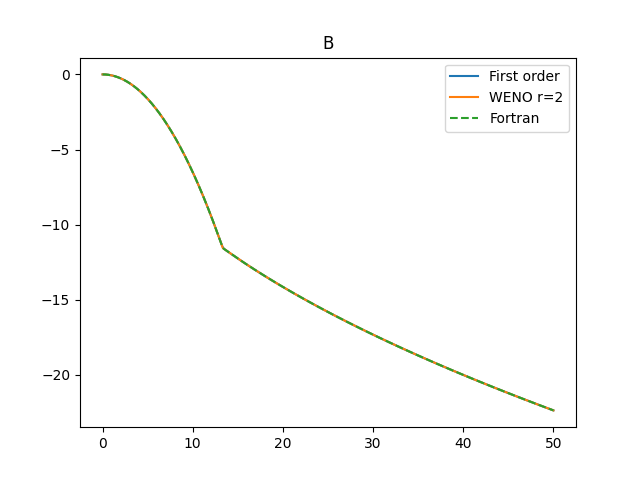

In [6]:
t = '2'
dx = '0.01'
f = 'B'

fig = plt.figure()
plt.plot(godunov[t][dx][f][k]['x'], godunov[t][dx][f][k]['B'], label = 'First order')
plt.plot(wenor2[t][dx][f][k]['x'], wenor2[t][dx][f][k]['B'], label = 'WENO r=2')

plt.plot(fx, fB, '--', label = 'Fortran')

plt.title(r"B")
plt.legend()



print(f"Time = {t}")
print(f"dx = {dx}")